In [43]:
import matplotlib
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ray
import json
import os
import mlflow

In [44]:
import os
import gym
import ray
import tqdm
import json
import pickle
import argparse
from os import path
from dynaconf import Dynaconf
from ray.rllib.algorithms.dqn import DQN
from replay_buffer.ber import BlockReplayBuffer
from ray.rllib.utils.replay_buffers import ReplayBuffer
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind
from ray.tune.logger import UnifiedLogger
from utils import convert_np_arrays, check_path

In [45]:
mlflow.set_tracking_uri("http://10.56.238.20:9999")
client = mlflow.MlflowClient()

In [46]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create a color palette
palette = sns.color_palette("colorblind", 4)

# Create a dictionary that maps each unique value to a color
palette_dict = dict(zip([1, 4, 8, 16], palette))

In [47]:
experiments = { "BeamRider": {}, "Qbert": {}, "SpaceInvaders": {}, "Breakout": {}}
configs = { "BeamRider": {}, "Qbert": {}, "SpaceInvaders": {}, "Breakout": {}}
mapper = {"Qbert": "Q*bert", "BeamRider": "BeamRider", "SpaceInvaders": "SpaceInvaders", "Breakout": "Breakout"}

In [48]:
selected = {
    "Qbert": ['DDQN_PBER_QbertNoFrameskip_20230731',
              'DDQN_PER_QbertNoFrameskip_20230731'],
    "Breakout": ['DDQN_PER_BreakoutNoFrameskip_20230802', 
                 'DDQN_PBER_BreakoutNoFrameskip_20230802'],
    "SpaceInvaders": ['DDQN_PBER_SpaceInvadersNoFrameskip_20230721',
                      'DDQN_PER_SpaceInvadersNoFrameskip_20230721'],
    "BeamRider": ['DDQN_PBER_BeamRiderNoFrameskip_20230721',
                  'DDQN_PER_BeamRiderNoFrameskip_20230721'],
}

In [49]:
for each in experiments.keys():
    path = os.path.join("/home/seventheli/backup/Local/Loggings/", each)
    config = os.path.join("/home/seventheli/backup/Local/Checkpoints", each)
    for experiment in selected[each]:
        experiments[each][experiment] = []
        experiment_id = client.get_experiment_by_name(mapper[each]).experiment_id
        mlflow_run = client.search_runs(experiment_ids=str(experiment_id), filter_string="attributes.run_name='%s'"% experiment)
        location = os.path.join(path, experiment)
        config_location = os.path.join(config, experiment)
        if not os.path.exists(location) and mlflow_run:            
            raise Exception
        for file in os.listdir(location):
            try:
                with open(os.path.join(location, file), "r") as f:
                    experiments[each][experiment].append(json.load(f))
            except:
                print(file)
        configs[each][experiment] = [mlflow_run[0].data.params["type"], mlflow_run[0].data.params.get("sub_buffer_size", 1)]

.ipynb_checkpoints


In [50]:
for games in selected.keys():
    _ = []
    for i in selected[games]:
        _config = configs[games][i]
        if _config[0] == "MultiAgentPrioritizedBlockReplayBuffer" and i[0:4] == "DDQN":
            _.append([i, _config[1], "PBER"])
        elif _config[0] == "MultiAgentPrioritizedReplayBuffer" and i[0:4] == "DDQN":
            _.append([i, 1, "PER"])
    selected[games] = _

In [51]:
sampler = {}
tags = ["episode_reward_max", "episode_reward_min", "episode_reward_mean", "episodes_this_iter"]

for each in selected.keys():
    selected_experiments = []
    for select in selected[each]:
        steps = []
        for info in experiments[each][select[0]]:
            _info = {
                **{i: info["sampler_results"][i] for i in tags},
                **info["counters"],
                **info["timers"],
                **{
                    "episodes_total": info["episodes_total"],
                    "training_iteration": info["training_iteration"],
                    "time_this_iter_s": info["time_this_iter_s"],
                    "time_total_s": info["time_total_s"]
                },
                **info["info"].get("learner", {"time_usage": {}}).get("time_usage", {})
            }
            steps.append(_info)
        steps = pd.DataFrame(steps).sort_values("time_total_s")
        steps["buffer"] = select[2]
        steps["size"] = int(select[1])
        steps["exp"] = select[0]
        steps["env"] = each.replace("NoFrameskip-v4", "")
        selected_experiments.append(steps.copy())
    try:
        sampler[each] = pd.concat(selected_experiments)
    except:
        pass

In [52]:
pd.concat([i[1].copy() for i in sampler.items()]).to_csv("./ex_per.csv", index=False)

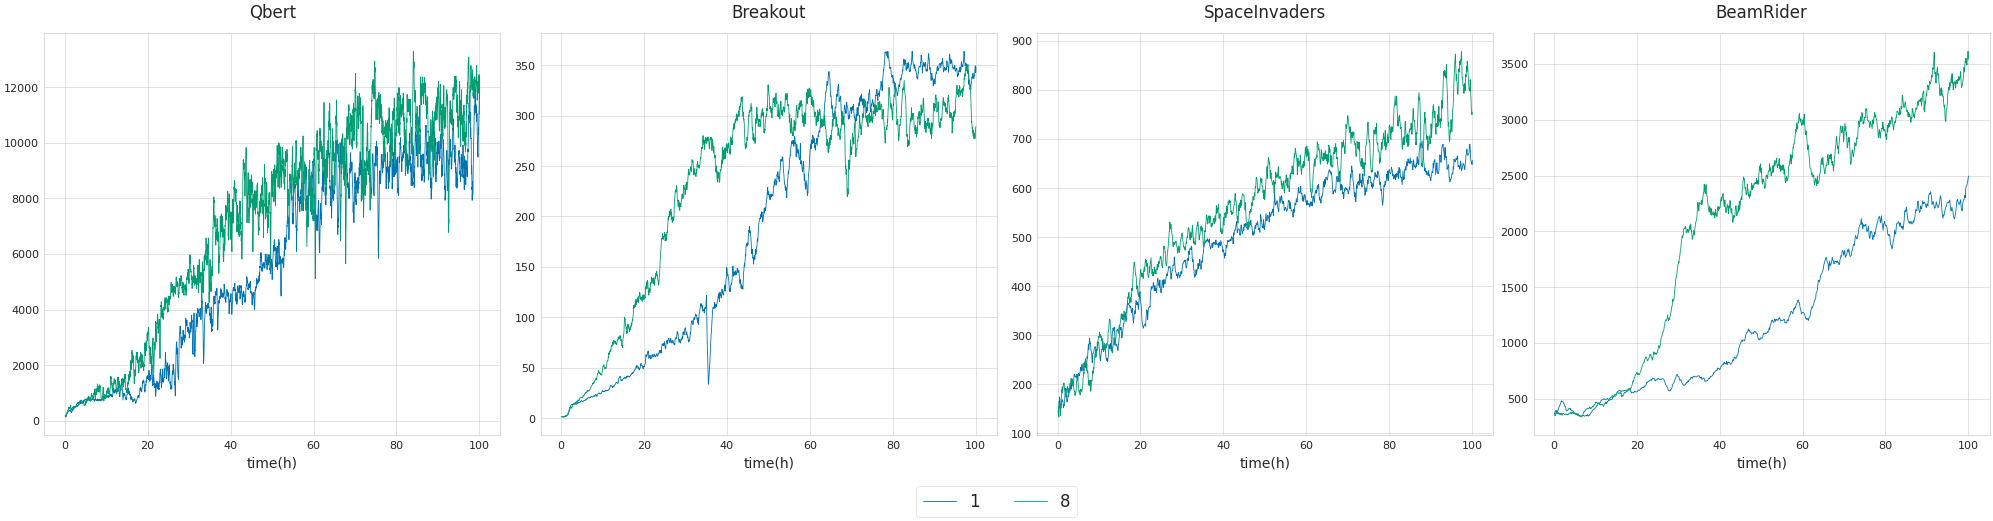

In [53]:
fig, axes = plt.subplots(1, 4, figsize=(50,12), dpi=40)
axes = axes.reshape(-1)
lines_labels = []
labels = {}

for ax_n, (experiment, data) in enumerate(sampler.items()):
    _data = data.copy()[["training_iteration", "num_env_steps_sampled", "num_env_steps_trained",
                         "time_total_s", "episode_reward_max", "episode_reward_min",
                         "episode_reward_mean", "size"]]
    _data.columns = ["training iteration", "sampled frame", "trained frame", "time(s)",
                     "episode reward(max)", "episode reward(min)", "episode reward(mean)",
                     "size"]
    _data["sampled frame"] = _data["sampled frame"] * 4
    _data["trained frame"] = _data["trained frame"] * 4
    _data["time(h)"] = _data["time(s)"] / 3600
    _data = _data[_data["time(h)"] > 0.1]
    ax = sns.lineplot(x="time(h)", y="episode reward(mean)", hue="size",
                      data=_data.reset_index(drop=True), linewidth=1.5, ax=axes[ax_n], palette=palette_dict)
    ax.set_title(experiment, fontsize=30, y=1.03)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.xaxis.offsetText.set_fontsize(20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.yaxis.offsetText.set_fontsize(20)
    ax.set_ylabel(None)
    if ax_n != 0:
        ax.get_legend().remove()
    else:
        lines_labels.extend(ax.get_legend_handles_labels() for ax in fig.axes)
        ax.get_legend().remove()
    if ax_n // 4 == 0:
        ax.set_xlabel("time(h)", fontsize=25, labelpad=10)
    else:
        ax.set_xlabel(None)

for j in lines_labels:
    for i in zip(*j):
        labels[i[1]] = i[0]
labels, lines = [i[0] for i in list(labels.items())], [i[1] for i in list(labels.items())]

# Adjusting the legend's location
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 0), ncol=4, fontsize=30)

# plt.subplots_adjust(bottom=-0.15)
plt.tight_layout()
plt.savefig("./images/experiments/rl_e_per.png")
plt.show()

In [54]:
pd.concat([pd.read_csv("./ex_per.csv"), pd.read_csv("./ex_er.csv")]).to_csv("ex_all.csv", index=False)

/home/seventheli/conda/envs/hpc/lib/python3.9/site-packages/seaborn/utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


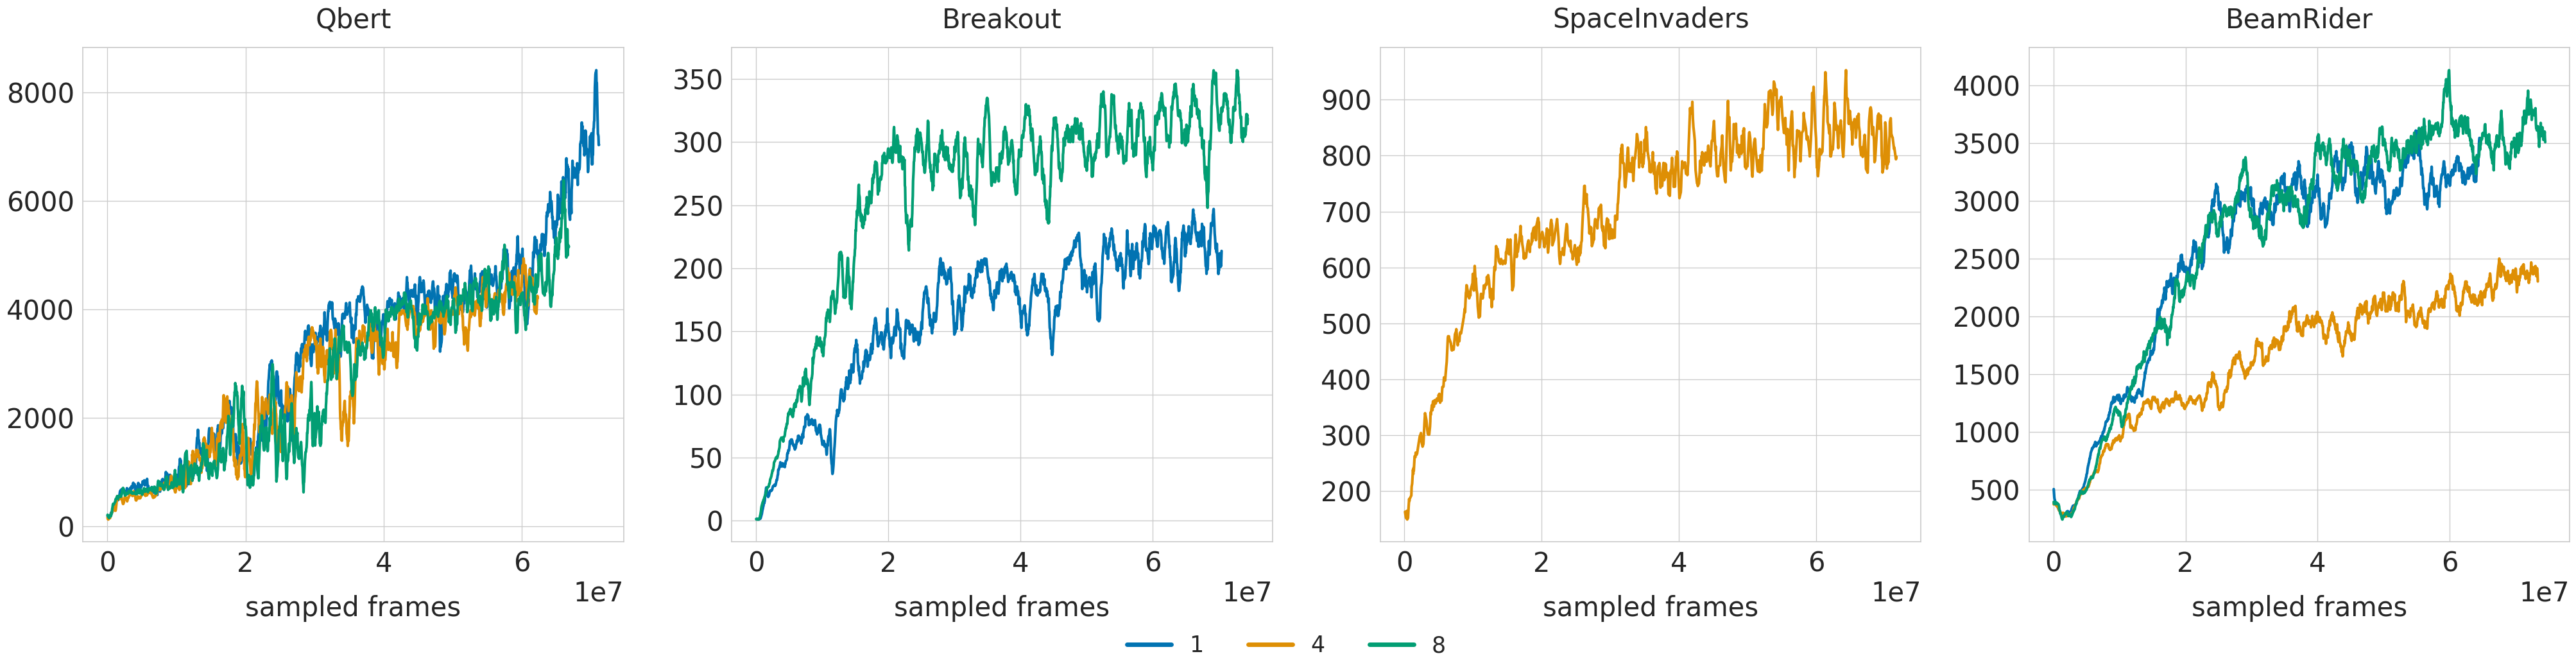

In [11]:
from matplotlib.ticker import FuncFormatter

def x_formatter(x, pos):
    return '{:.2f}e7'.format(x/1e7)

fig, axes = plt.subplots(1, 4, figsize=(50,10), dpi=100)
axes = axes.reshape(-1)
lines_labels = []
labels = {}
for ax_n, (experiment, data) in enumerate(sampler.items()):
    _data = data.copy()[["training_iteration", "num_env_steps_sampled", "time_total_s",
                         "episode_reward_max", "episode_reward_min", "episode_reward_mean", 
                         "size"]]
    _data.columns = ["training iteration", "sampled frame", "time(s)",
                     "episode reward(max)", "episode reward(min)", "episode reward(mean)",
                     "size"]
    _data["sampled frame"] = _data["sampled frame"] * 4
    ax = sns.lineplot(x="sampled frame", y="episode reward(mean)", hue="size",
                      data=_data.reset_index(drop=True), linewidth=3, ax=axes[ax_n], palette=palette_dict)
    ax.set_title(experiment, fontsize=30, y=1.03)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.xaxis.offsetText.set_fontsize(30)
    ax.yaxis.set_tick_params(labelsize=30)
    ax.yaxis.offsetText.set_fontsize(30)
    ax.set_ylabel(None)
    if ax_n != 0:
        ax.get_legend().remove()
    else:
        lines_labels.extend(ax.get_legend_handles_labels() for ax in fig.axes)
        ax.get_legend().remove()
    if ax_n // 4 == 0:
        ax.set_xlabel("sampled frames", fontsize=30, labelpad=20)
    else:
        ax.set_xlabel(None)

for j in lines_labels:
    for i in zip(*j):
        labels[i[1]] = i[0]
labels, lines = [i[0] for i in list(labels.items())], [i[1] for i in list(labels.items())]
for i in lines:
    i.set_linewidth(5.0) 
fig.legend(lines, labels, loc="center right")
sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.5,  -0.1), ncol=6, title=None, frameon=False, fontsize=25
)


/home/seventheli/conda/envs/hpc/lib/python3.9/site-packages/seaborn/utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


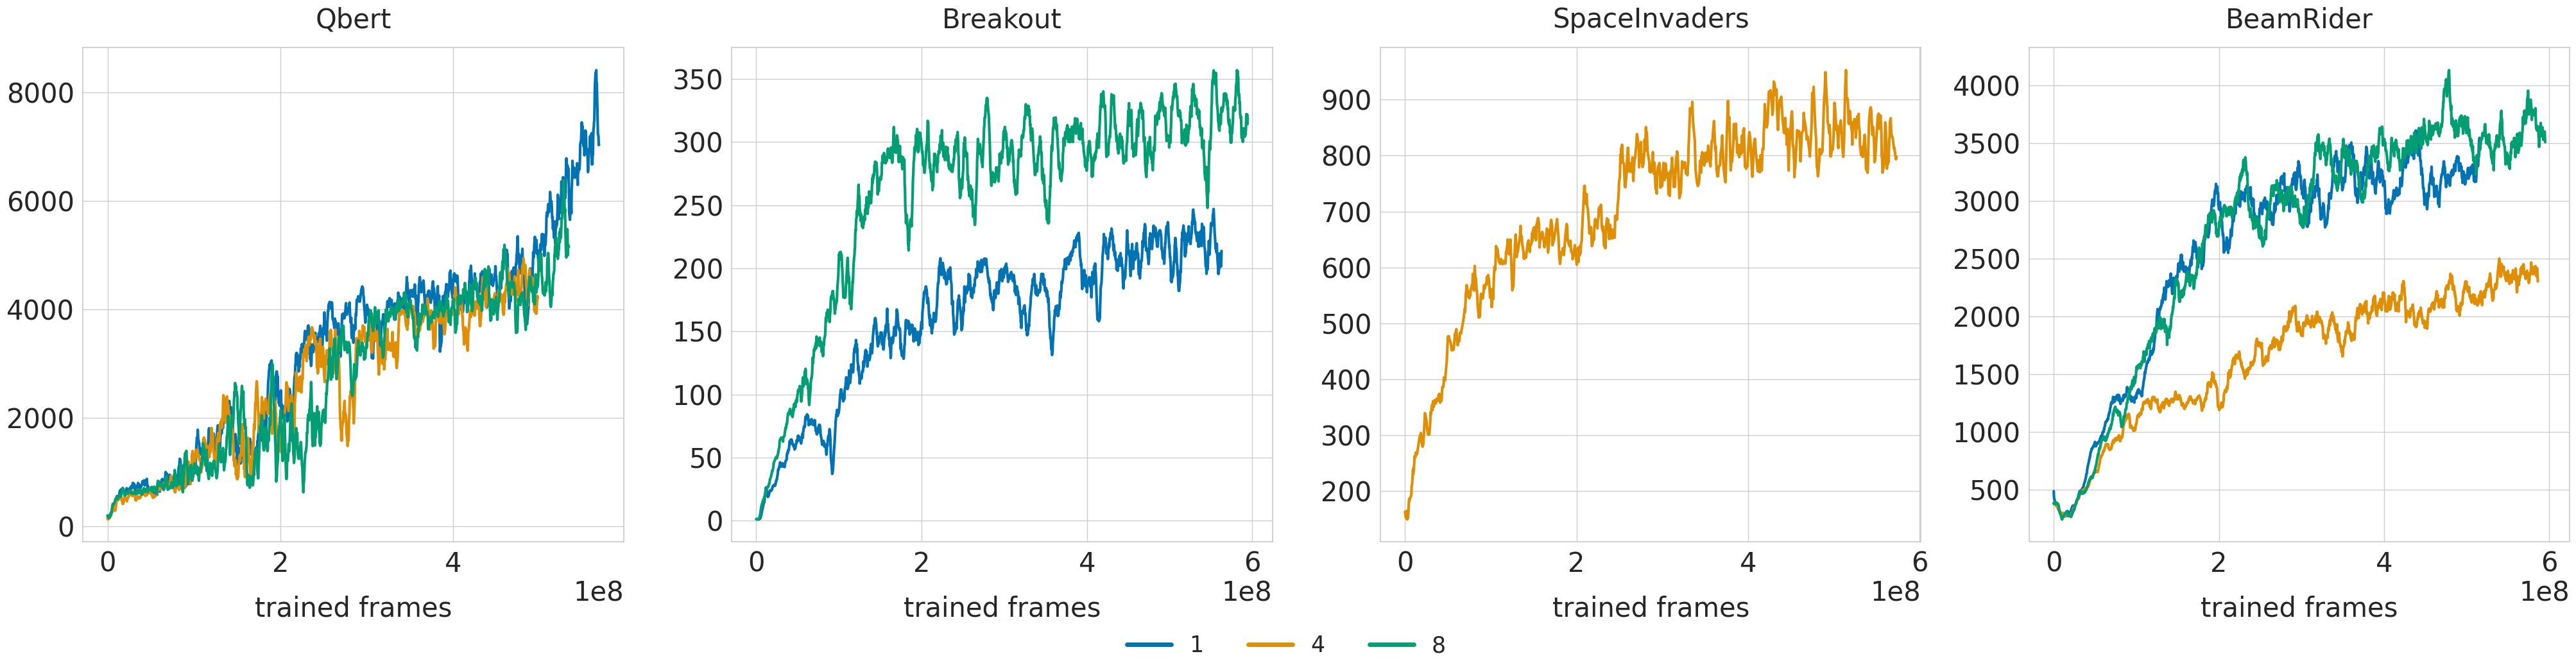

In [12]:
from matplotlib.ticker import FuncFormatter

def x_formatter(x, pos):
    return '{:.2f}e7'.format(x/1e7)

fig, axes = plt.subplots(1, 4, figsize=(50,10), dpi=100)
axes = axes.reshape(-1)
lines_labels = []
labels = {}
for ax_n, (experiment, data) in enumerate(sampler.items()):
    _data = data.copy()[["training_iteration", "num_agent_steps_trained", "time_total_s",
                         "episode_reward_max", "episode_reward_min", "episode_reward_mean", 
                         "size"]]
    _data.columns = ["training iteration", "trained frame", "time(s)",
                     "episode reward(max)", "episode reward(min)", "episode reward(mean)",
                     "size"]
    _data["trained frame"] = _data["trained frame"] * 4
    ax = sns.lineplot(x="trained frame", y="episode reward(mean)", hue="size", 
                      data=_data.reset_index(drop=True), linewidth=3, ax=axes[ax_n], palette=palette_dict)
    ax.set_title(experiment, fontsize=30, y=1.03)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.xaxis.offsetText.set_fontsize(30)
    ax.yaxis.set_tick_params(labelsize=30)
    ax.yaxis.offsetText.set_fontsize(30)
    ax.set_ylabel(None)
    if ax_n != 0:
        ax.get_legend().remove()
    else:
        lines_labels.extend(ax.get_legend_handles_labels() for ax in fig.axes)
        ax.get_legend().remove()
    if ax_n // 4 == 0:
        ax.set_xlabel("trained frames", fontsize=30, labelpad=20)
    else:
        ax.set_xlabel(None)

for j in lines_labels:
    for i in zip(*j):
        labels[i[1]] = i[0]
labels, lines = [i[0] for i in list(labels.items())], [i[1] for i in list(labels.items())]
for i in lines:
    i.set_linewidth(5.0) 
fig.legend(lines, labels, loc="center right")
sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.5,  -0.1), ncol=6, title=None, frameon=False, fontsize=25
)


/home/seventheli/conda/envs/hpc/lib/python3.9/site-packages/seaborn/utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


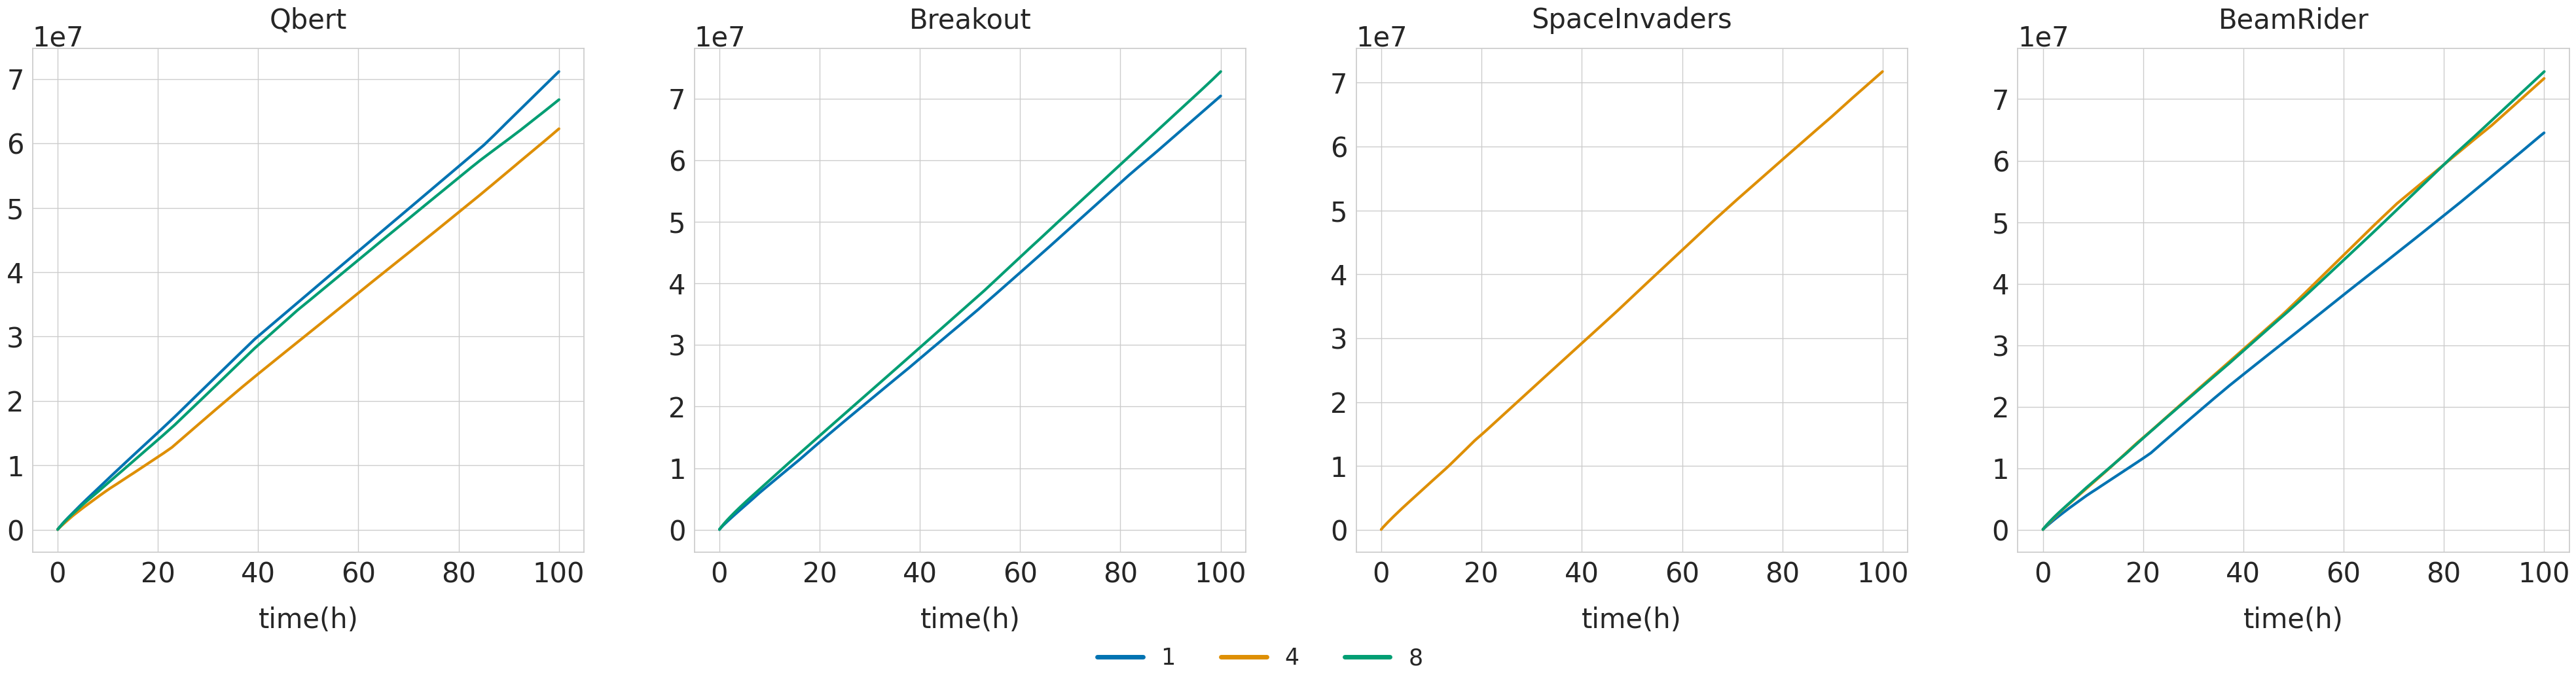

In [15]:
from matplotlib.ticker import FuncFormatter

def x_formatter(x, pos):
    return '{:.2f}e7'.format(x/1e7)

fig, axes = plt.subplots(1, 4, figsize=(50,10), dpi=100)
axes = axes.reshape(-1)
lines_labels = []
labels = {}
for ax_n, (experiment, data) in enumerate(sampler.items()):
    _data = data.copy()[["training_iteration", "num_env_steps_sampled", "time_total_s",
                         "episode_reward_max", "episode_reward_min", "episode_reward_mean", 
                         "size"]]
    _data.columns = ["training iteration", "sampled frame", "time(s)",
                     "episode reward(max)", "episode reward(min)", "episode reward(mean)",
                     "size"]
    _data["sampled frame"] = _data["sampled frame"] * 4
    _data["time(h)"] = _data["time(s)"] / 3600
    ax = sns.lineplot(x="time(h)", y="sampled frame", hue="size",
                      data=_data.reset_index(drop=True), linewidth=3, ax=axes[ax_n], palette=palette_dict)
    ax.set_title(experiment, fontsize=30, y=1.03)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.xaxis.offsetText.set_fontsize(30)
    ax.yaxis.set_tick_params(labelsize=30)
    ax.yaxis.offsetText.set_fontsize(30)
    ax.set_ylabel(None)
    if ax_n != 0:
        ax.get_legend().remove()
    else:
        lines_labels.extend(ax.get_legend_handles_labels() for ax in fig.axes)
        ax.get_legend().remove()
    if ax_n // 4 == 0:
        ax.set_xlabel("time(h)", fontsize=30, labelpad=20)
    else:
        ax.set_xlabel(None)

for j in lines_labels:
    for i in zip(*j):
        labels[i[1]] = i[0]
labels, lines = [i[0] for i in list(labels.items())], [i[1] for i in list(labels.items())]
for i in lines:
    i.set_linewidth(5.0) 
fig.legend(lines, labels, loc="center right")
sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(.5,  -0.1), ncol=6, title=None, frameon=False, fontsize=25
)
